In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df_train = pd.read_csv('/kaggle/input/tcr-attencross-data/train.csv')
df_train = df_train.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
tcr_features = df_train.filter(like='TCR_').columns
hla_features = df_train.columns.drop(tcr_features).drop('label')
X_tcr_train = df_train[tcr_features]
X_hla_train = df_train[hla_features]
y_train = df_train['label']
y = df_train['label']
df_test = pd.read_csv('/kaggle/input/tcr-attencross-data/test.csv')
df_test = df_test.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
X_tcr_test = df_test[tcr_features]
X_hla_test = df_test[hla_features]
y_test = df_test['label']
df_independed = pd.read_csv('/kaggle/input/tcr-attencross-data/independent_test.csv')
X_tcr_independed = df_independed[tcr_features]
X_hla_independed = df_independed[hla_features]
y_independed = df_independed['label']

In [2]:
class TCR_pMHC_Cross(nn.Module):
    def __init__(self, input_dim_1=5, input_dim_2=1, seq_len_1=20, seq_len_2=60, d_model=64):
        super(TCR_pMHC_Cross, self).__init__()
        self.positional_encoding_1 = nn.Parameter(torch.randn(1, seq_len_1, d_model))
        self.positional_encoding_2 = nn.Parameter(torch.randn(1, seq_len_2, d_model))
        self.linear_in_1 = nn.Linear(input_dim_1, d_model) 
        self.linear_in_2 = nn.Linear(input_dim_2, d_model)
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=4, batch_first=True)
        self.layer_norm = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x1, x2):
        x2 = x2.unsqueeze(-1)
        x1 = self.linear_in_1(x1) + self.positional_encoding_1
        x2 = self.linear_in_2(x2) + self.positional_encoding_2
        attn_output, _ = self.cross_attn(query=x2, key=x1, value=x1)
        x1_norm = self.layer_norm(attn_output + x2)
        ff_output = self.feed_forward(x1_norm)
        output = self.layer_norm(ff_output + x1_norm)
        return output

    
class THACrossModel(nn.Module):
    def __init__(self):
        super(THACrossModel, self).__init__()
        input_features = 64 + 20*5 + 60
        self.fc_sequence = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 2),
            nn.Sigmoid()
        )
        self.tcr_pMHC = TCR_pMHC_Cross()

    def forward(self, x_tcr, x_antigen_hla):
        x_tcr_flat = x_tcr.view(x_tcr.size(0), -1)
        tcr_pMHC_matrix = self.tcr_pMHC(x_tcr, x_antigen_hla)
        tcr_pMHC_flat = tcr_pMHC_matrix.mean(dim=1)
        x = torch.cat((x_tcr_flat, x_antigen_hla, tcr_pMHC_flat), dim=1)
        out = self.fc_sequence(x) 
        return out

In [3]:
def train(model, train_loader, val_loader, loss_function, optimizer, epochs=5):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train() 
        total_loss = 0 
        for X_tcr_batch, X_hla_batch, y_batch in train_loader:
            X_tcr_batch, X_hla_batch, y_batch = X_tcr_batch.to(device), X_hla_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()  
            outputs = model(X_tcr_batch, X_hla_batch) 
            loss = loss_function(outputs, y_batch.squeeze()) 
            loss.backward()  
            optimizer.step()  
            total_loss += loss.item() 
        
        train_losses.append(total_loss / len(train_loader))
        
        model.eval()  
        total_val_loss = 0
        correct = 0  
        with torch.no_grad():  
            for X_tcr_batch, X_hla_batch, y_batch in val_loader:
                X_tcr_batch, X_hla_batch, y_batch = X_tcr_batch.to(device), X_hla_batch.to(device), y_batch.to(device)
                outputs = model(X_tcr_batch, X_hla_batch)  
                total_val_loss += loss_function(outputs, y_batch.squeeze()).item()  
                predicted = outputs.argmax(dim=1)  
                correct += (predicted == y_batch.squeeze()).sum().item() 
        
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(correct / len(val_loader.dataset))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}")
    
    return train_losses, val_losses, val_accuracies

In [4]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
batch_size = 128
X_tcr_np = X_tcr_train.to_numpy().astype(np.float32).reshape(-1, 20, 5)
X_tcr_tensor = torch.tensor(X_tcr_np)
X_hla_np = X_hla_train.to_numpy().astype(np.float32)
X_hla_tensor = torch.tensor(X_hla_np)
y_tensor = torch.tensor(y_train.to_numpy()).long()
y_tensor = y_tensor.reshape(y_tensor.shape[0],1)##
X_tcr_train_, X_tcr_val_, X_hla_train_, X_hla_val_, y_train_, y_val_ = train_test_split(
    X_tcr_tensor, X_hla_tensor, y_tensor, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_tcr_train_, X_hla_train_, y_train_)
val_dataset = TensorDataset(X_tcr_val_, X_hla_val_, y_val_)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = THACrossModel().to(device)
print(model)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_losses, val_losses, val_accuracies = train(model, train_loader, val_loader, loss_function, optimizer, epochs=200)

THACrossModel(
  (fc_sequence): Sequential(
    (0): Linear(in_features=224, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1024, out_features=2, bias=True)
    (7): Sigmoid()
  )
  (tcr_pMHC): TCR_pMHC_Cross(
    (linear_in_1): Linear(in_features=5, out_features=64, bias=True)
    (linear_in_2): Linear(in_features=1, out_features=64, bias=True)
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (feed_forward): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
)
Epoch 1, Train Loss: 0.6931310586273078, Val Loss: 0.6930147753242074,

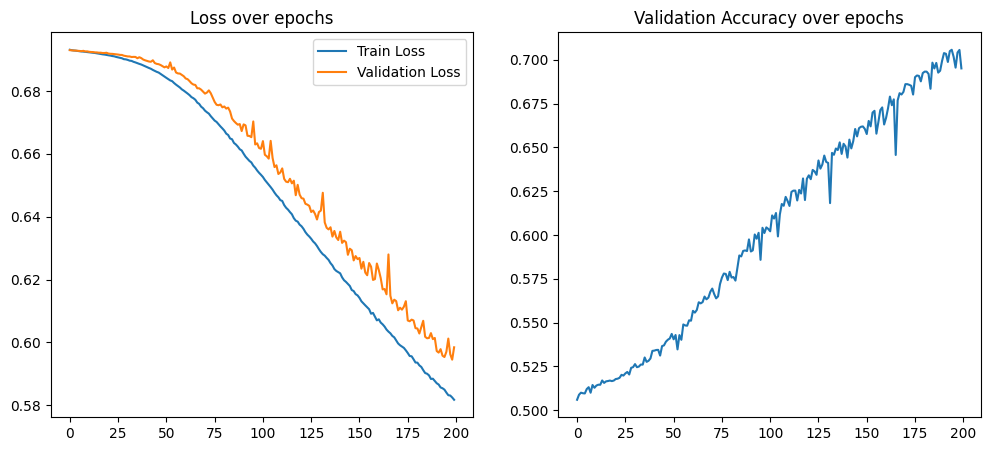

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy over epochs')
plt.show()

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, precision_recall_fscore_support
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax
from sklearn.metrics import matthews_corrcoef

X_tcr_test_np = X_tcr_test.to_numpy().astype(np.float32).reshape(-1, 20, 5)
X_hla_test_np = X_hla_test.to_numpy().astype(np.float32)
y_test_np = y_test.to_numpy().astype(np.int64)
X_tcr_test_tensor = torch.tensor(X_tcr_test_np)
X_hla_test_tensor = torch.tensor(X_hla_test_np)
y_test_tensor = torch.tensor(y_test_np).long()
test_dataset = TensorDataset(X_tcr_test_tensor, X_hla_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
prob_predictions = []
predictions = []
real_labels = []

with torch.no_grad():
    for X_tcr_batch, X_hla_batch, y_batch in test_loader:
        X_tcr_batch, X_hla_batch, y_batch = X_tcr_batch.to(device), X_hla_batch.to(device), y_batch.to(device)
        logits = model(X_tcr_batch, X_hla_batch)
        _, predicted = torch.max(logits.data, 1)
        probs = softmax(logits, dim=1)[:, 1]  
        predictions.extend(predicted.cpu().numpy())
        prob_predictions.extend(probs.cpu().numpy())
        real_labels.extend(y_batch.cpu().numpy())

predictions = np.array(predictions)
prob_predictions = np.array(prob_predictions)
real_labels = np.array(real_labels).flatten()

results_df = pd.DataFrame({
    'Predictions': predictions,
    'Probability Predictions': prob_predictions,
    'Real Labels': real_labels
})
results_df.to_csv('test_results.csv', index=False)

In [7]:
X_tcr_test_np = X_tcr_independed.to_numpy().astype(np.float32).reshape(-1, 20, 5)
X_hla_test_np = X_hla_independed.to_numpy().astype(np.float32)
y_test_np = y_independed.to_numpy().astype(np.int64)
X_tcr_test_tensor = torch.tensor(X_tcr_test_np)
X_hla_test_tensor = torch.tensor(X_hla_test_np)
y_test_tensor = torch.tensor(y_test_np).long()
test_dataset = TensorDataset(X_tcr_test_tensor, X_hla_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
prob_predictions = []
predictions = []
real_labels = []

with torch.no_grad():
    for X_tcr_batch, X_hla_batch, y_batch in test_loader:
        X_tcr_batch, X_hla_batch, y_batch = X_tcr_batch.to(device), X_hla_batch.to(device), y_batch.to(device)
        logits = model(X_tcr_batch, X_hla_batch)
        _, predicted = torch.max(logits.data, 1)
        probs = softmax(logits, dim=1)[:, 1]  
        predictions.extend(predicted.cpu().numpy())
        prob_predictions.extend(probs.cpu().numpy())
        real_labels.extend(y_batch.cpu().numpy())

predictions = np.array(predictions)
prob_predictions = np.array(prob_predictions)
real_labels = np.array(real_labels).flatten()

results_df = pd.DataFrame({
    'Predictions': predictions,
    'Probability Predictions': prob_predictions,
    'Real Labels': real_labels
})
results_df.to_csv('independed_results.csv', index=False)